# How to use deep_tabular_augmentation

### The main idea of why and how to use Deep Learning to create data augmentation on tabular data is decribed in my previous blogpost on this topic. Since then quite some time has passed and I decided to rewrite the Code so it is easier to use. In this blogpost I want to show you how to use the new approach, how flexible it is regarding the model you want to use and how you can use your own custom Callbacks to better see what the model does in the background. Some of these features I already built-in and here's how to use them.

Again, we use the credit-card fraud dataset from kaggle.

In [3]:
from config import *

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = 'data/creditcard.csv'

df = pd.read_csv(DATA_PATH, sep=',')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The deep_tabular_augmentation works on the simple idea, that we want to keep the data in a dedicated class (which we call the Learner) together with the model. The data has to come as a dataloader object, which I store in the DataBunch class. In it are the dataloaders for the training and test data. The runner class then defines the flow. 

We first scale the data and only keep the data of the class we want to augment:

In [5]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='Class', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_fraud = X_train_scaled[np.where(y_train==1)[0]]
X_test_fraud = X_test_scaled[np.where(y_test==1)[0]]

As mentioned, I then put the train and testloader into a class called DataBunch, which is just a container for the data. You can easily create your own dataloaders and put them in a DataBunch.

In [7]:
device = DEVICE
datasets = dta.create_datasets(X_train_fraud, y_train.values[np.where(y_train==1)], X_test_fraud, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

To make use of the deep_data_augmentation, we need to specify the input shape (so basically how many variables are in the dataset), the column name of the target-class we want to augment and the corresponding number, and lastly the column names of the input variables.

Then, wen can define whatever model architecture we would like to have. We just pass it as a list into the model. We can also define how many latent dimension we would like to add to our Autoencoder. 

In [8]:
D_in = X_train_fraud.shape[1]
target_name = 'Class'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

We put all these information within the Learner class. This is where we keep everything attached to the data and model:

In [9]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

The runner class then provides us with the flow of the data and also let's you add Callbacks. One of the built-in Classbacks is a Learning Rate Finder, and this is how you can use it:

In [10]:
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

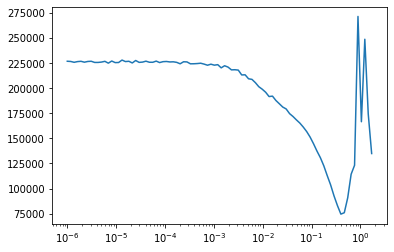

In [12]:
run.recorder.plot(skip_last=5)

We can also use the callbacks to create a learning rate scheduler. Here is an example: use 30% of the budget to go from 0.01 to 0.1 following a cosine, then the last 70% of the budget to go from 0.1 to 0.01, still following a cosine.

In [13]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.05), dta.sched_cos(0.05, 0.01)])

Now we can train our Autoencoder. We want to keep track of the loss, we want to be able to do some loss plotting and we want to add our learning-rate scheduling:

In [14]:
cbfs = [partial(dta.LossTracker, show_every=200), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(1000, learn)

epoch: 200
train loss is: 225114.875
validation loss is: 115246.5859375
epoch: 400
train loss is: 106772.5546875
validation loss is: 63919.203125
epoch: 600
train loss is: 61763.24609375
validation loss is: 43108.23046875
epoch: 800
train loss is: 44581.90625
validation loss is: 33015.5390625
epoch: 1000
train loss is: 35748.265625
validation loss is: 27532.025390625


We can have a look at the training loss:

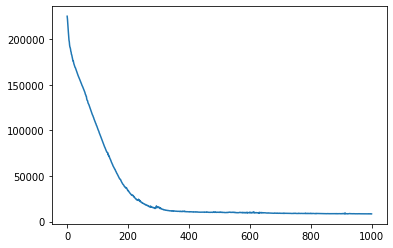

In [15]:
run.recorder.plot_loss()

And the learnig rate over the epochs:

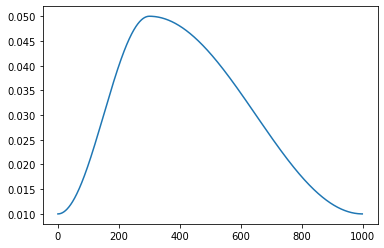

In [17]:
run.recorder.plot_lr()

You can create any kind of Callbacks you want and pass them to the training. Within the runner I created some hooks after which you can directly link your Callback, for example *begin_batch*, *begin_epoch*, *after_pred*, *after_fit* and quite a few more. When you create your Callback you can directly refer to these to pinpoint where your Callback should do specific tasks. This is how the LossTracker looks like:

In [19]:
class LossTracker(dta.Callback):
    def __init__(self, show_every): self.show_every = show_every

    def begin_fit(self):
        self.train_losses = []
        self.val_losses = []
    
    def after_batch(self):
        if self.in_train:
            self.train_losses.append(self.loss.detach().cpu()) 
        else:
            self.val_losses.append(self.loss.detach().cpu())

    def after_epoch(self):
        if self.run.epoch % self.show_every==0:
            print(f'epoch: {self.run.epoch + self.show_every}')
            print(f'train loss is: {sum(self.train_losses)/len(self.train_losses)}')
            print(f'validation loss is: {sum(self.val_losses)/len(self.val_losses)}')

When beginning the training, I start with an empty list, and after each batch I add the loss. After each epoch then I print the loss.

Moreover, the runner also provides you with the possibility to create augmented data by the trained model. You can specify how many samples of the specified class you want, and you can also add some noise to it, which I found to create better input for later use.

In [36]:
df_fake = run.predict_df(learn, no_samples=10000, scaler=x_scaler)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=10000, mu=0, sigma=0.1, scaler=x_scaler)
df_fake.describe().loc[['mean']]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,84246.492188,-3.907873,3.267383,-3.435851,4.335964,-2.274521,1.734463,-8.014628,-10.251186,-1.38874,...,-4.401209,2.359375,0.597872,-0.423079,-0.59408,-0.067904,0.246678,0.08693,82.072906,1.0


In [37]:
df[df['Class']==1].groupby('Class').describe().loc[:,(slice(None),['mean'])]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Class,,,,,,,,,,,,,,,,,,,,,
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.10513,0.041449,0.051648,0.170575,0.075667,122.211321


In [38]:
df[df['Class']==0].groupby('Class').describe().loc[:,(slice(None),['mean'])]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.00786,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000644,-0.001235,-0.000024,0.00007,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022


Let's see how our model does when it comes to replicating the fraud cases. First we plot V1 against V2 on the non-fraud cases, then we do the same for the fraud cases:

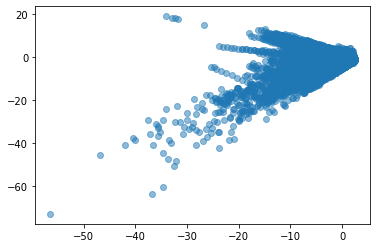

In [39]:
import matplotlib.pyplot as plt
plt.scatter(df[df['Class']==0]['V1'].values, df[df['Class']==0]['V2'].values, alpha=0.5)
plt.show()

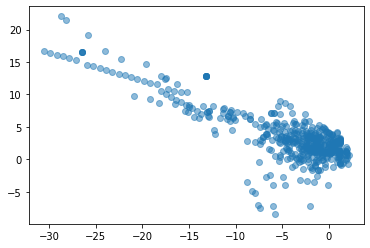

In [40]:
plt.scatter(df[df['Class']==1]['V1'].values, df[df['Class']==1]['V2'].values, alpha=0.5)
plt.show()

They look quite different. Let's see how our fake data does:

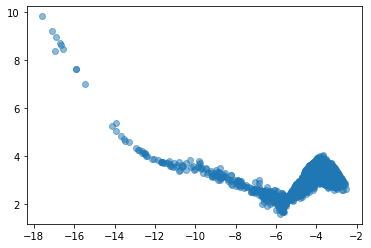

In [41]:
plt.scatter(df_fake['V1'].values, df_fake['V2'].values, alpha=0.5)
plt.show()

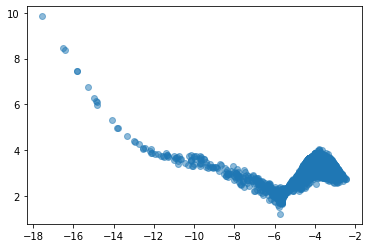

In [42]:
plt.scatter(df_fake_with_noise['V1'].values, df_fake_with_noise['V2'].values, alpha=0.5)
plt.show()

This looks actually quite amazing. If you have any questions or want anything added to the package, just ask me.

Lasse